In [1]:
import gym
import numpy as np 
from itertools import count
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.pipeline
import sklearn.preprocessing

import sys
if "../" not in sys.path:
  sys.path.append("../") 

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

env = gym.envs.make("MountainCar-v0")
env._max_episode_steps = 2000


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Hyperparameters

In [35]:
NUM_FEATURIZERS = 4
NUM_FEATURES = NUM_FEATURIZERS * 10
GAMMA = 0.99
LAMBDA = 0.5
ALPHA = 1e-3

## Base class for Policy Gradient Linear Model
This is the abstract class to later define the Actor (the policy) & the Critic (the value function approximator)

In [36]:
class PolicyGradient(object):
    def __init__(self, num_features, _examples):
        '''
        num_features: define len of weights vector of the linear model (used as either Actor or Critic)
        _examples: sample for either observation space or (obs, act) space to normalize the scaler to 
                    zero mean & unit variance
        '''
        assert num_features % NUM_FEATURIZERS == 0
        self.weights = np.zeros(num_features)
        # define & normalize scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(_examples)
        # define featurizer
        num_components = num_features // 4
        self.featurizer = state_featurizer = sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=num_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=num_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=num_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=num_components))
                ])
        self.featurizer.fit(self.scaler.transform(_examples))
        # init eligibilities trace
        self.elig_trace = np.zeros(num_features)
        
    def featurize(self, *argv):
        '''
        Accepted input: state or state, action
        '''
        assert len(argv) in [1, 2]
        if len(argv) == 2:
            # featurize a (state, action) pair
            scaled = self.scaler.transform([np.append(argv[0], argv[1])])
        else:
            # featurize a state
            scaled = self.scaler.transform([argv[0]])
        # invoke the featurizer
        featurized = self.featurizer.transform(scaled)
        return featurized[0]
    
    def update_weights(self):
        raise NotImplementedError()
    
    def update_elig_trace(self):
        raise NotImplementedError()

## Critic - Value Function Approximator

In [37]:
class ValueApprox(PolicyGradient):
    def __init__(self, num_features):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        super().__init__(num_features, observation_examples)
    
    def cal_state_value(self, state):
        return self.featurize(state).dot(self.weights)
    
    def update_weights(self, td_error):
        self.weights += ALPHA * td_error * self.elig_trace
    
    def update_elig_trace(self, state):
        self.elig_trace = GAMMA * LAMBDA * self.elig_trace + self.featurize(state) 

# test
value_func = ValueApprox(8)
state = env.observation_space.sample()
print("ex features vector:\n",value_func.featurize(state))
print("ex state value:\n", value_func.cal_state_value(state))
value_func.update_elig_trace(state)

ex features vector:
 [-0.26236815 -0.97764568  0.81764551  0.90326507 -0.56467521 -0.94342943
  0.87236497 -0.83279482]
ex state value:
 0.0


## Actor - Softmax Policy

In [38]:
class Policy(PolicyGradient):
    def __init__(self, num_features):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        action_examples = np.array([env.action_space.sample() for x in range(1000)])
        obs_act_examples = np.concatenate((observation_examples, action_examples.reshape((-1, 1))), axis=1)
        super().__init__(num_features, obs_act_examples)
        self.score = None
    
    def choose_action(self, state):
        '''
        Choose an action at state s & calculate the score of this action (grad of log(policy))
        the score is stored in attribute score
        '''
        act_prob = np.zeros(env.action_space.n)
        features_mat = np.zeros((env.action_space.n, self.weights.shape[0]))
        for act in range(env.action_space.n):
            features_mat[act, :] = self.featurize(state, act)
            act_prob[act] = np.exp(features_mat[act, :].dot(self.weights))
        act_prob /= act_prob.sum()  # normalize act_prob
        choosen_act = np.argmax(act_prob)
        # Update score of this state & chosen action pair
        self.score = features_mat[choosen_act, :] - features_mat.mean(axis=0)
        # update actor eligibility trace
        self.update_elig_trace()
        return choosen_act
    
    def update_weights(self, td_error):
        self.weights += ALPHA * td_error * self.elig_trace
    
    def update_elig_trace(self):
        self.elig_trace = GAMMA * LAMBDA * self.elig_trace + self.score
    

# Test
policy = Policy(8)
action = env.action_space.sample()
print(policy.featurize(state, action))
act = policy.choose_action(state)
print("choose action:\t", act)
print("score:\n", policy.score)
policy.update_elig_trace()

[ 0.08658425 -0.2506406  -0.14316163 -0.9998028   0.57336736  0.98987463
 -0.57815446  0.99946857]
choose action:	 0
score:
 [ 0.85165079  0.24625386  0.10500591  0.94833749 -0.99513112 -0.7730865
  0.37623982 -0.25472869]


## Statistic

In [39]:
def plotValueFunc(value_approx):
    x_vect = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=50)
    xdot_vect = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=50)
    x, xdot = np.meshgrid(x_vect, xdot_vect)
    state_value = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            state = np.array([x[i, j], xdot[i, j]])
            state_value[i, j] = value_approx.cal_state_value(state)
    # plot Value function
    fig = plt.figure(100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, xdot, -state_value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    plt.show()

In [40]:
dict_steps_per_episode = {}

## Training Loop

In [41]:
for LAMBDA in np.linspace(0, 1, num=6):
    dict_steps_per_episode[LAMBDA] = []
    # Create policy object & value approx. object
    policy = Policy(NUM_FEATURES)
    value_approx = ValueApprox(NUM_FEATURES)

    max_episode = 20
    for i_episode in range(max_episode):
        state = env.reset()
        action = policy.choose_action(state)
        for step in count():
            # update critic eligibility trace
            value_approx.update_elig_trace(state)
            # take action and observe next state & reward
            next_state, reward, done, _ = env.step(action)
            if next_state[0] > 0.45:
                reward = 1.0
                done = True
            # calculate TD error
            if not done:
                next_action = policy.choose_action(next_state)
                td_error = reward + GAMMA * value_approx.cal_state_value(next_state) - \
                                            value_approx.cal_state_value(state)
            else:
                next_action = None
                td_error = reward - value_approx.cal_state_value(state)
            # Update weights of Actor & Critic
            policy.update_weights(td_error)
            value_approx.update_weights(td_error)
            if done:
                print("Episode %d finishes after %d steps" % (i_episode, step + 1))
                break
            else:
                if step % 500 == 0: print("Episode %d\tTD error = " % i_episode, td_error)
            # move on
            action = next_action
            state = next_state
        dict_steps_per_episode[LAMBDA].append(step)
    print("------- End GAMMA = %.1f ----------" % LAMBDA)
    

Episode 0	TD error =  -1.0
Episode 0	TD error =  -0.9210351932521212
Episode 0	TD error =  -0.9201101811654167
Episode 0	TD error =  -1.0895736705036647
Episode 0 finishes after 2000 steps
Episode 1	TD error =  -0.9619513708401399
Episode 1	TD error =  -0.7890504749370653
Episode 1	TD error =  -0.8176218451014243
Episode 1	TD error =  -1.1422500156113902
Episode 1 finishes after 2000 steps
Episode 2	TD error =  -0.9479511762524933
Episode 2	TD error =  -1.0018566471599595
Episode 2	TD error =  -0.8424165045309664
Episode 2	TD error =  -0.9556628978767261
Episode 2 finishes after 2000 steps
Episode 3	TD error =  -0.9188115401868799
Episode 3	TD error =  -0.8083014386524461
Episode 3	TD error =  -0.7381499656608375
Episode 3	TD error =  -0.27256808540030697
Episode 3 finishes after 2000 steps
Episode 4	TD error =  -0.807308870638586
Episode 4	TD error =  -1.2655809864513294
Episode 4	TD error =  -1.8930967047305316
Episode 4	TD error =  -0.5334116012759846
Episode 4 finishes after 2000 s

Episode 0 finishes after 1703 steps
Episode 1	TD error =  -0.899406836675217
Episode 1	TD error =  -0.7448500535985509
Episode 1	TD error =  -0.9683764490599351
Episode 1 finishes after 1495 steps
Episode 2	TD error =  -0.8672047475109714
Episode 2	TD error =  -0.7604231855886496
Episode 2 finishes after 813 steps
Episode 3	TD error =  -0.7500517840045049
Episode 3	TD error =  -0.5664172684381619
Episode 3	TD error =  -1.4224459629841908
Episode 3 finishes after 1019 steps
Episode 4	TD error =  -0.763383796403069
Episode 4 finishes after 430 steps
Episode 5	TD error =  -0.6849767698813132
Episode 5 finishes after 465 steps
Episode 6	TD error =  -0.8130198493674179
Episode 6	TD error =  -1.2316053646295515
Episode 6 finishes after 677 steps
Episode 7	TD error =  -0.6205990957312082
Episode 7 finishes after 167 steps
Episode 8	TD error =  -0.8805273336668122
Episode 8	TD error =  -0.681346388102682
Episode 8 finishes after 683 steps
Episode 9	TD error =  -0.6578715459384838
Episode 9 fin

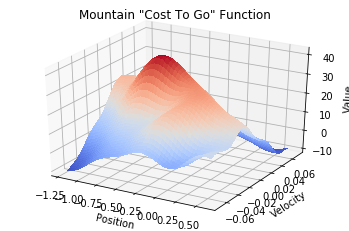

In [30]:
plotValueFunc(value_approx)

## Compare learning rate among TD(lambda)

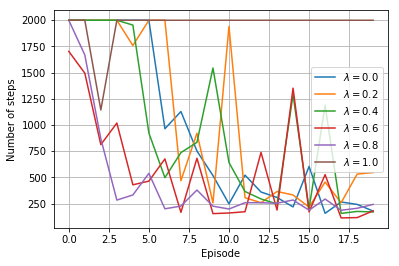

In [43]:
plt.figure(1)
for l in dict_steps_per_episode.keys():
    plt.plot(dict_steps_per_episode[l], label=r"$\lambda = $" + "%.1f"%l)
plt.grid()
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Number of steps")
plt.show()

In [68]:
np.savetxt('mountain_car_td_AC_policy_weights.txt', policy.weights, fmt='%f')